# Nutrient Requirements of Conventionally and Organically Grown Cranberry (*Vaccinium macrocarpon* Ait.)

**Computations by Serge-Étienne Parent and S.M.Reza Jamaly**

When managing cranberry nutrition, growers are most interested in determining the factor(s) that limit growth and yield. In this notebook, we correlate the performance of cranberry production with fertilizers.

The performance of cranberry production can be assessed by the following metrics.

- number of flowers per reporductive uprights (count)
- fruit set (ratio of berry counts to flower counts)
- berry counts per fruiting upright (count)
- average berry weight ($g \cdot berry^{-1}$)
- marketable yield ($Mg \cdot ha^{-1}$)
- berry quality
  - total anthocyanins (TAcy)
  - total soluble solids (Brix)
  - firmness

We tested fertilizers provides the following nutrients: N, P, K, Mg, Cu, B, and S.

## Initiate session

To initiate the session, we load the following libraries.

In [1]:
library('tidyverse') # generic data handling and plotting
library('nlme') # mixed models
library('caret') # machine learning
library('ggthemr') # prettify ggplot
ggthemr("fresh")

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.0       ✔ purrr   0.3.2  
✔ tibble  2.0.1       ✔ dplyr   0.8.0.1
✔ tidyr   0.8.3       ✔ stringr 1.4.0  
✔ readr   1.3.1       ✔ forcats 0.4.0  
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘nlme’

The following object is masked from ‘package:dplyr’:

    collapse

Loading required package: lattice

Attaching package: ‘caret’

The following object is masked from ‘package:purrr’:

    lift



All data are placed in a single csv file.

In [2]:
pr <- read_csv(file="data/performance-fertilisation.csv")

Parsed with column specification:
cols(
  .default = col_double(),
  Cropping_system = col_character(),
  Treatment = col_character(),
  Fertilizer_type = col_character(),
  Fertilizer = col_character(),
  Site = col_character()
)
See spec(...) for full column specifications.


### Arrange data

A couple of data handling is needed for the analysis. First, some variable types must be changed.

1. the Bloc column refers to an experimental unit, not a continuous variable.
2. the Fertilizer column is a fertilizer type, i.e. a factor

Then, yield was markedly reduced by 75% in 2017 due to adverse meteorological conditions in winter and spring. Year 2017 was thus discarded, I'm considering only data before 2017.

In [3]:
pr <- pr %>%
  mutate(Bloc = factor(Bloc),
         Fertilizer = factor(Fertilizer)) %>%
  filter(Year < 2017)

We create a vector containing the column names of performance indicator.

In [4]:
performance_index <- colnames(pr)[10:21]
performance_index

[1] "TAcy"            "Brix"            "Firmness"        "Berry_weight"   
 [5] "Yield"           "Flower_stem"     "Flower"          "Flower_per_stem"
 [9] "Fruit_stem"      "Fruit"           "Fruit_per_stem"  "Fruit_set"

Another object contains the names of the fertilizer treatment.

In [5]:
treatments <- unique(pr$Fertilizer)
treatments

[1] N  P  K  B  Cu Mg S 
Levels: B Cu K Mg N P S

## Mixed modeling

Combination of performance-treatment will be subjected to a mixed model, but some with a linear model, and other with a quadratic model. Moreover, some combinaisons of performance-treatment were not tested. We aim to loop each possible combinaison to fit a linear model, a quadratic model or no model at all. The first step of this process is to create a grid of these combinaisons.

In [6]:
model_conditions <- expand.grid(performance_index = performance_index, 
                               Fertilizer = treatments)
model_conditions$index <- 1:nrow(model_conditions)

We are adding a column to the grid containing the information on which option to choose. By default, the option is linear.

In [7]:
model_conditions$model_type = 'linear'

Where the modeling threw erors due to lack of data, I imposed `'none'` as `model_type`.

In [8]:
model_conditions$model_type[model_conditions$Fertilizer == 'B' & model_conditions$performance_index == 'Brix'] <- 'none'
model_conditions$model_type[model_conditions$Fertilizer == 'S' & model_conditions$performance_index == 'Flower_stem'] <- 'none'
model_conditions$model_type[model_conditions$Fertilizer == 'S' & model_conditions$performance_index == 'Flower'] <- 'none'
model_conditions$model_type[model_conditions$Fertilizer == 'S' & model_conditions$performance_index == 'Flower_per_stem'] <- 'none'
model_conditions$model_type[model_conditions$Fertilizer == 'S' & model_conditions$performance_index == 'Fruit_stem'] <- 'none'
model_conditions$model_type[model_conditions$Fertilizer == 'S' & model_conditions$performance_index == 'Fruit'] <- 'none'
model_conditions$model_type[model_conditions$Fertilizer == 'S' & model_conditions$performance_index == 'Fruit_per_stem'] <- 'none'
model_conditions$model_type[model_conditions$Fertilizer == 'S' & model_conditions$performance_index == 'Fruit_set'] <- 'none'

The following instructions impose a quadratic model to some combinaisons. We selected quadratic where it visually seemed appropriate.

In [9]:
model_conditions$model_type[model_conditions$Fertilizer == 'N' & model_conditions$performance_index == "Yield"] <- 'quadratic'
model_conditions$model_type[model_conditions$Fertilizer == 'N' & model_conditions$performance_index == "Berry_weight"] <- 'quadratic'
model_conditions$model_type[model_conditions$Fertilizer == 'K' & model_conditions$performance_index == "Yield"] <- 'quadratic'
model_conditions$model_type[model_conditions$Fertilizer == 'K' & model_conditions$performance_index == "Berry_weight"] <- 'quadratic'

### Effect of nitrogen source

We hypothesized ($H0$) that cranberry quality, berry yield and yield components don't respond to N and K fertilization and N sources.  We test the linear and quadratic effects of Rate and the linear effect of fertilizer type. We extract the effect of the fertilizer type from the model.

The following cell runs mixed models on nitrogen trials and save them in a list.

In [10]:
lmm_N <- list()
interval_lmmN <- list()

mc_N <- model_conditions %>% 
  filter(Fertilizer == "N")

for (i in 1:nrow(mc_N)) {
  performance_i <- as.character(mc_N[i, 1])
  model_type_i <- mc_N[i, 4]
  
  table_mm_i <- pr %>%
    filter(Fertilizer == "N") %>%
    select(one_of(c('Year','Site','Bloc','Rate','Cropping_system', 'Fertilizer_type', performance_i))) %>%
    drop_na()
    
  if (model_type_i == 'linear') {
    lmm_N[[i]] <- lme(as.formula(paste0(performance_i, " ~ Rate + Fertilizer_type ")),
                    random = ~ 1 + 1|Year/Site/Bloc,
                    data = table_mm_i)      
  } else if (model_type_i == 'quadratic') {
    lmm_N[[i]] <- lme(as.formula(paste0(performance_i, " ~ Rate + I(Rate^2) + Fertilizer_type")),
                    random = ~ 1 + 1|Year/Site/Bloc,
                    data = table_mm_i)
  } else if (model_type_i == 'none') {
    lmm_N[[i]] <- NA
  } else {
    print("Model type not recognized. Choose linear or quadratic.")
  }
    
  tTable <- summary(lmm_N[[i]])$tTable%>%
    data.frame() %>%
    rownames_to_column() %>%
    filter(str_detect(rowname, 'Fert'))
  
  intervals <- intervals(lmm_N[[i]], which = "fixed")[[1]] %>%
    data.frame() %>%
    rownames_to_column() %>%
    filter(str_detect(rowname, 'Fert')) %>%
    bind_cols(tTable["p.value"])
  
  intervals$is_significant <- factor(ifelse(intervals$p.value <= 0.05, "significant", "not significant"))
  
  intervals$performance <- mc_N$performance_index[i]
  
  interval_lmmN[[i]] <- intervals
}
interval_lmmN <- do.call(rbind.data.frame, interval_lmmN)

Prettier performance indexes and fertilizer type.

In [11]:
interval_lmmN <- interval_lmmN %>%
  mutate(performance = factor(performance,
                              labels = c("TAcy~plain('(')~mg~100^{-1}~plain(')')",
                                         "{}^o~Brix",
                                         "Firmness~plain('(')~N~sec^{-1}~plain(')')",
                                         "Berry~weight~plain('(')~g~plain(')')",
                                         "Berry~yield~plain('(')~Mg~ha^{-1}~plain(')')",
                                         "Reproductive~upright~plain('(')~m^{-2}~plain(')')",
                                         "Flower~count~plain('(')~m^{-2}~plain(')')",
                                         "Flower~per~repr.~upright~plain('(')~m^{-2}~plain(')')",
                                         "Fruiting~upright~plain('(')~m^{-2}~plain(')')",
                                         "Berry~count~plain('(')~m^{-2}~plain(')')",
                                         "Berry~per~fruiting~upright~plain('(')~m^{-2}~plain(')')",
                                         "Fruit~set~plain('(%)')")),
        rowname = factor(rowname,
                         labels = c('Fertilizer: 24-5-11',
                                    'Fertilizer:  6-1-1',
                                    'Fertilizer:  8-0-0')))

Slopes and their 95% confidence intervals are plotted for each performance index.

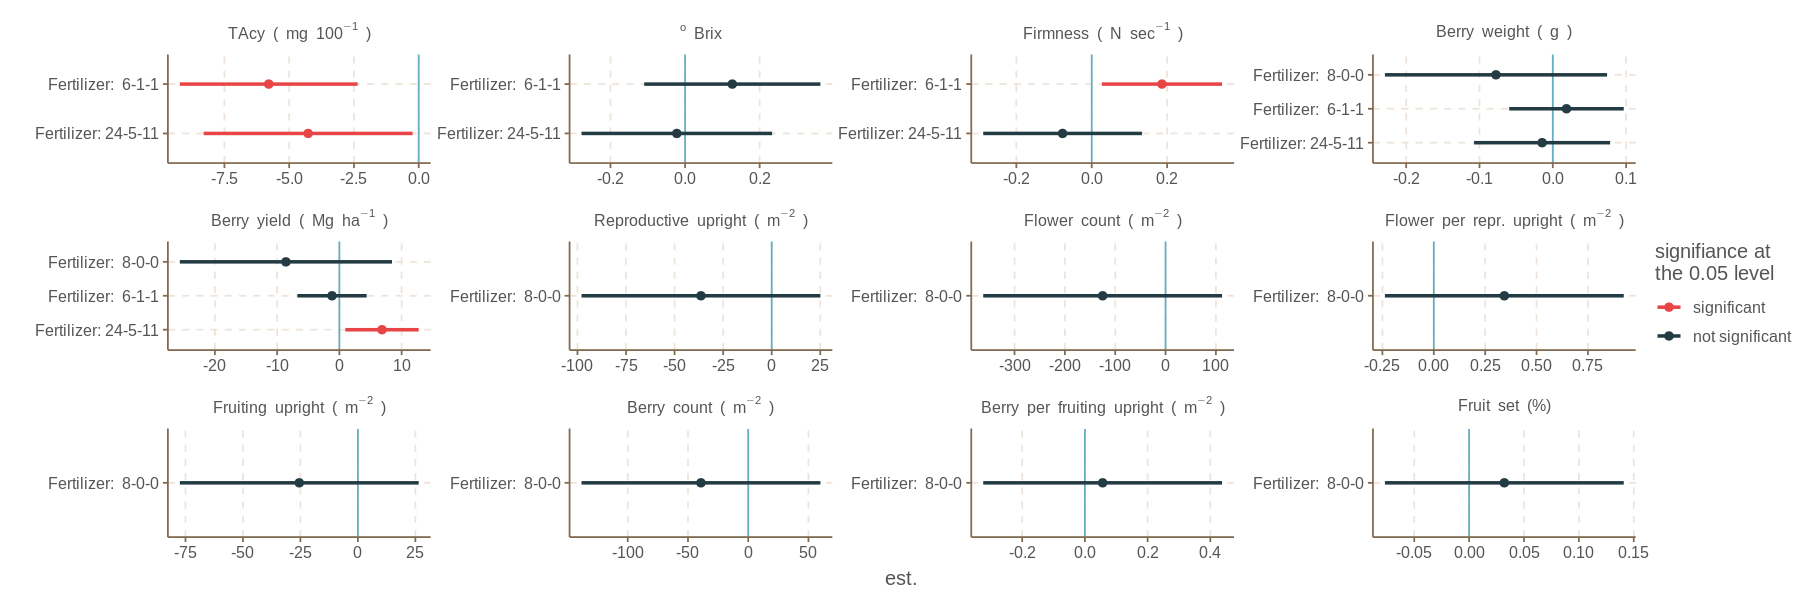

In [12]:
options(repr.plot.width = 15, repr.plot.height = 5)
interval_lmmN %>% ggplot(aes(x = est., y = rowname)) +
  facet_wrap(. ~ performance, scales = "free", labeller = label_parsed) +
  geom_vline(xintercept = 0, lty = 1) +
  geom_segment(mapping = aes(x = lower, xend = upper, 
                             yend = rowname,
                             colour = is_significant),
               size = 1) +
  geom_point(aes(colour = is_significant), size = 2) +
  labs(y = "", colour="signifiance at\nthe 0.05 level") +
  scale_colour_manual(values = swatch()[4:3]) +
  theme(strip.text.y = element_text(angle = 0))
ggsave("images/sources-nitrogen.pdf", width=15, height = 5, dpi=300)

### Effect of fertlizers and doses

For all fertlizers and perfomance indexes, we run a linear or quadratic model (disregarding the effect of fertilizer types for nitrogen).

In [13]:
alpha <- 0.05
lmm <- list()
pred <- list()

for (i in 1:nrow(model_conditions)) {
  performance_i <- as.character(model_conditions[i, 1])
  treatment_i <- model_conditions[i, 2]
  model_type_i <- model_conditions[i, 4]
  
  table_mm_i <- pr %>%
    filter(Fertilizer == treatment_i) %>%
    select(one_of(c('Year','Site','Bloc','Rate','Cropping_system', performance_i))) %>%
    drop_na()
  
  if (model_type_i == 'linear') {
    lmm[[i]] <- lme(as.formula(paste0(performance_i, " ~ Rate")),
                    random = ~ 1 + 1|Year/Site/Bloc,
                    data = table_mm_i)
      is_significant <- summary(lmm[[i]])$tTable[2, 5] <= alpha
      
  } else if (model_type_i == 'quadratic') {
    lmm[[i]] <- lme(as.formula(paste0(performance_i, " ~ Rate + I(Rate^2)")),
                    random = ~ 1 + 1|Year/Site/Bloc,
                    data = table_mm_i)
      is_significant <- summary(lmm[[i]])$tTable[3, 5] <= alpha
  } else if (model_type_i == 'none') {
    lmm[[i]] <- NA
      is_significant <- NA
  } else {
    print("Model type not recognized. Choose linear or quadratic.")
  }
  
  if (any(is.na(lmm[[i]]))) {
      pred[[i]] <- NA
  } else {
      x_seq <- expand.grid(Rate = seq(0, max(table_mm_i$Rate), length=20),
                             Year = c(2016))
      y_seq <- predict(lmm[[i]], newdata = x_seq, level = 0)
      pred[[i]] <- data.frame(Rate = x_seq$Rate,
                              performance = y_seq,
                              Fertilizer = treatment_i,
                              performance_index = performance_i,
                             is_significant = is_significant)
  }
}
pred <- do.call(rbind.data.frame, pred) # list to data frame
pred$`Slope p-value` <- ifelse(pred$is_significant, paste("≤", alpha), paste(">", alpha))
pred$`Slope p-value` <- factor(pred$`Slope p-value`, levels = c(paste("≤", alpha), paste(">", alpha)))
pred <- pred %>%
  mutate(is_significant = ifelse(is_significant, "significant", "not significant"))

Before plotting, the original data are gathered by performance indexes. We also order and prettify performance categories and nutrients.

In [14]:
pred <- pred %>%
 mutate(performance_index_pretty = factor(performance_index,
                                          labels = c("TAcy~plain('(')~mg~100^{-1}~plain(')')",
                                               "{}^o~Brix",
                                               "Firmness~plain('(')~N~sec^{-1}~plain(')')",
                                               "Berry~weight~plain('(')~g~plain(')')",
                                               "Berry~yield~plain('(')~Mg~ha^{-1}~plain(')')",
                                               "Reproductive~upright~plain('(')~m^{-2}~plain(')')",
                                               "Flower~count~plain('(')~m^{-2}~plain(')')",
                                               "Flower~per~repr.~upright~plain('(')~m^{-2}~plain(')')",
                                               "Fruiting~upright~plain('(')~m^{-2}~plain(')')",
                                               "Berry~count~plain('(')~m^{-2}~plain(')')",
                                               "Berry~per~fruiting~upright~plain('(')~m^{-2}~plain(')')",
                                               "Fruit~set~plain('(%)')")))

In [15]:
pr_tidy <- pr %>%
  gather(key = performance_index, value = performance, performance_index) %>%
  mutate(performance_index = factor(performance_index),
         performance_index_pretty = factor(performance_index,
                                          labels = c("Berry~weight~plain('(')~g~plain(')')",
                                                     "{}^o~Brix",
                                                     "Firmness~plain('(')~N~sec^{-1}~plain(')')",
                                                     "Flower~count~plain('(')~m^{-2}~plain(')')",
                                                     "Flower~per~repr.~upright~plain('(')~m^{-2}~plain(')')",
                                                     "Reproductive~upright~plain('(')~m^{-2}~plain(')')",
                                                     "Berry~count~plain('(')~m^{-2}~plain(')')",
                                                     "Berry~per~fruiting~upright~plain('(')~m^{-2}~plain(')')",
                                                     "Fruit~set~plain('(%)')",
                                                     "Fruiting~upright~plain('(')~m^{-2}~plain(')')",
                                                     "TAcy~plain('(')~mg~100^{-1}~plain(')')",
                                                     "Berry~yield~plain('(')~Mg~ha^{-1}~plain(')')")),
         Fertilizer = factor(Fertilizer, levels = c("N", "P", "K", "Mg", "S", "Cu", "B")))

Classifying performance indexes.

In [16]:
quality_index <- c("TAcy", "Brix", "Firmness", "Berry_weight", "Yield")
physiology_index <- c('Flower_stem', 'Flower', 'Flower_per_stem', 'Fruit_stem', 
                      'Fruit', 'Fruit_per_stem', 'Fruit_set')

Each fertilizer type and performance index data is plotted with the model.

#### Macro-elements

##### Quality

Warning message:
“Removed 576 rows containing missing values (geom_point).”

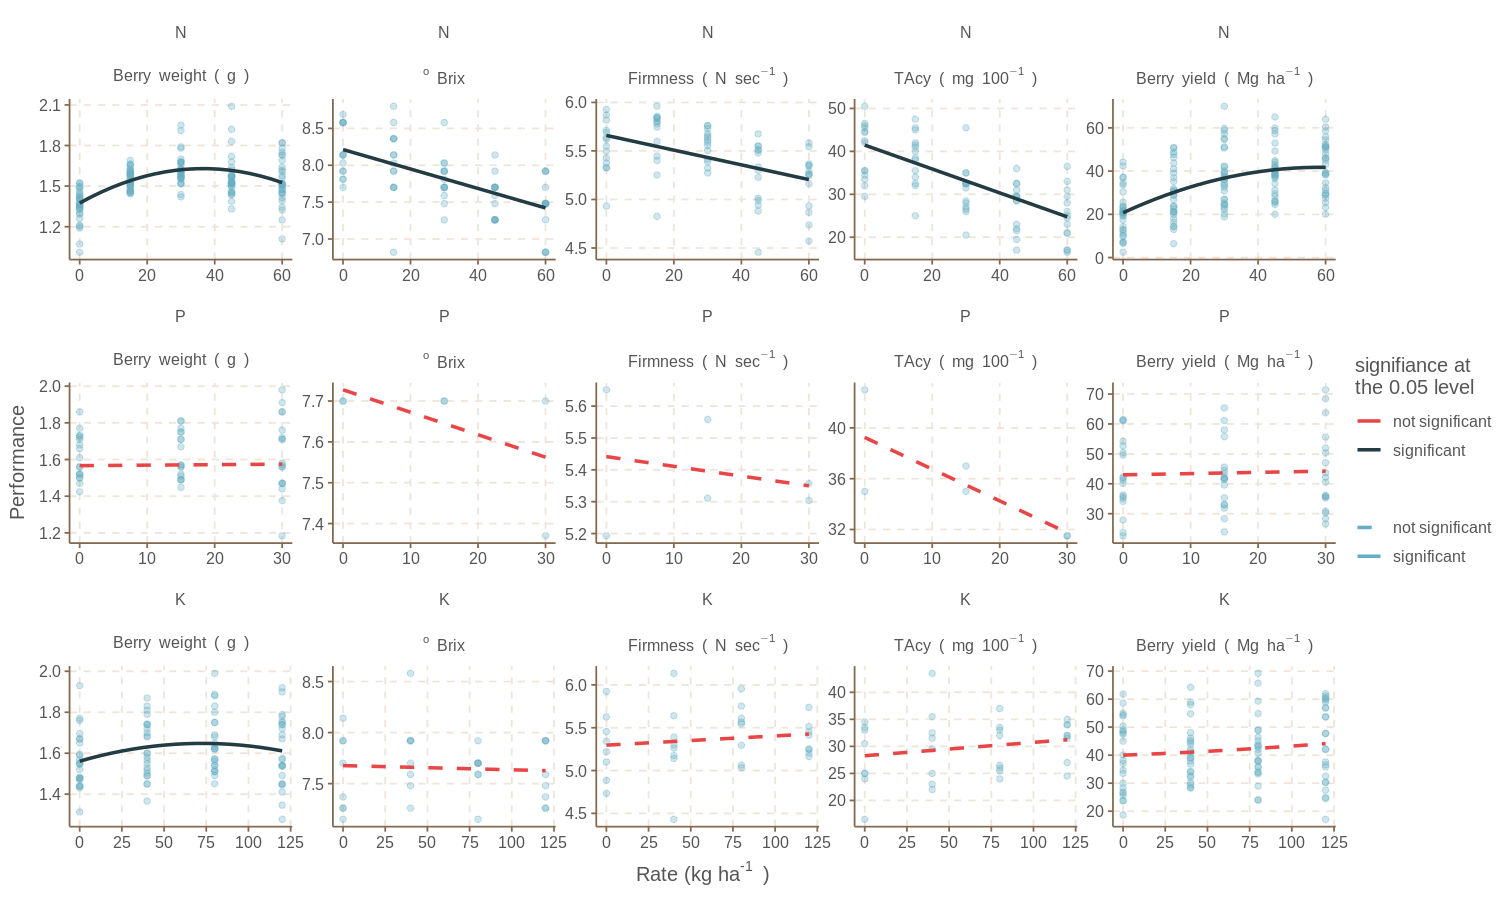

In [17]:
options(repr.plot.width = 5 * 2.5, repr.plot.height = 3 * 2.5)

pr_tidy %>%
  filter(Fertilizer %in% c("N", "P", "K") & performance_index %in% quality_index) %>%
  ggplot(aes(Rate, performance)) +
    facet_wrap(Fertilizer ~ performance_index_pretty, scales = "free", ncol = 5, labeller = label_parsed) +
    geom_point(alpha = 0.3) +
    geom_line(data = pred %>% filter(Fertilizer %in% c("N", "P", "K") & performance_index %in% quality_index) %>% drop_na(),
              aes(colour = is_significant, lty = is_significant), size = 1) +
    labs(x = expression("Rate (kg ha"^"-1"~")"), y = "Performance",
         colour = "signifiance at\nthe 0.05 level", lty = "") +
    scale_linetype_manual(values = c("dashed", "solid")) +
    scale_colour_manual(values = swatch()[4:3])

##### Physiology

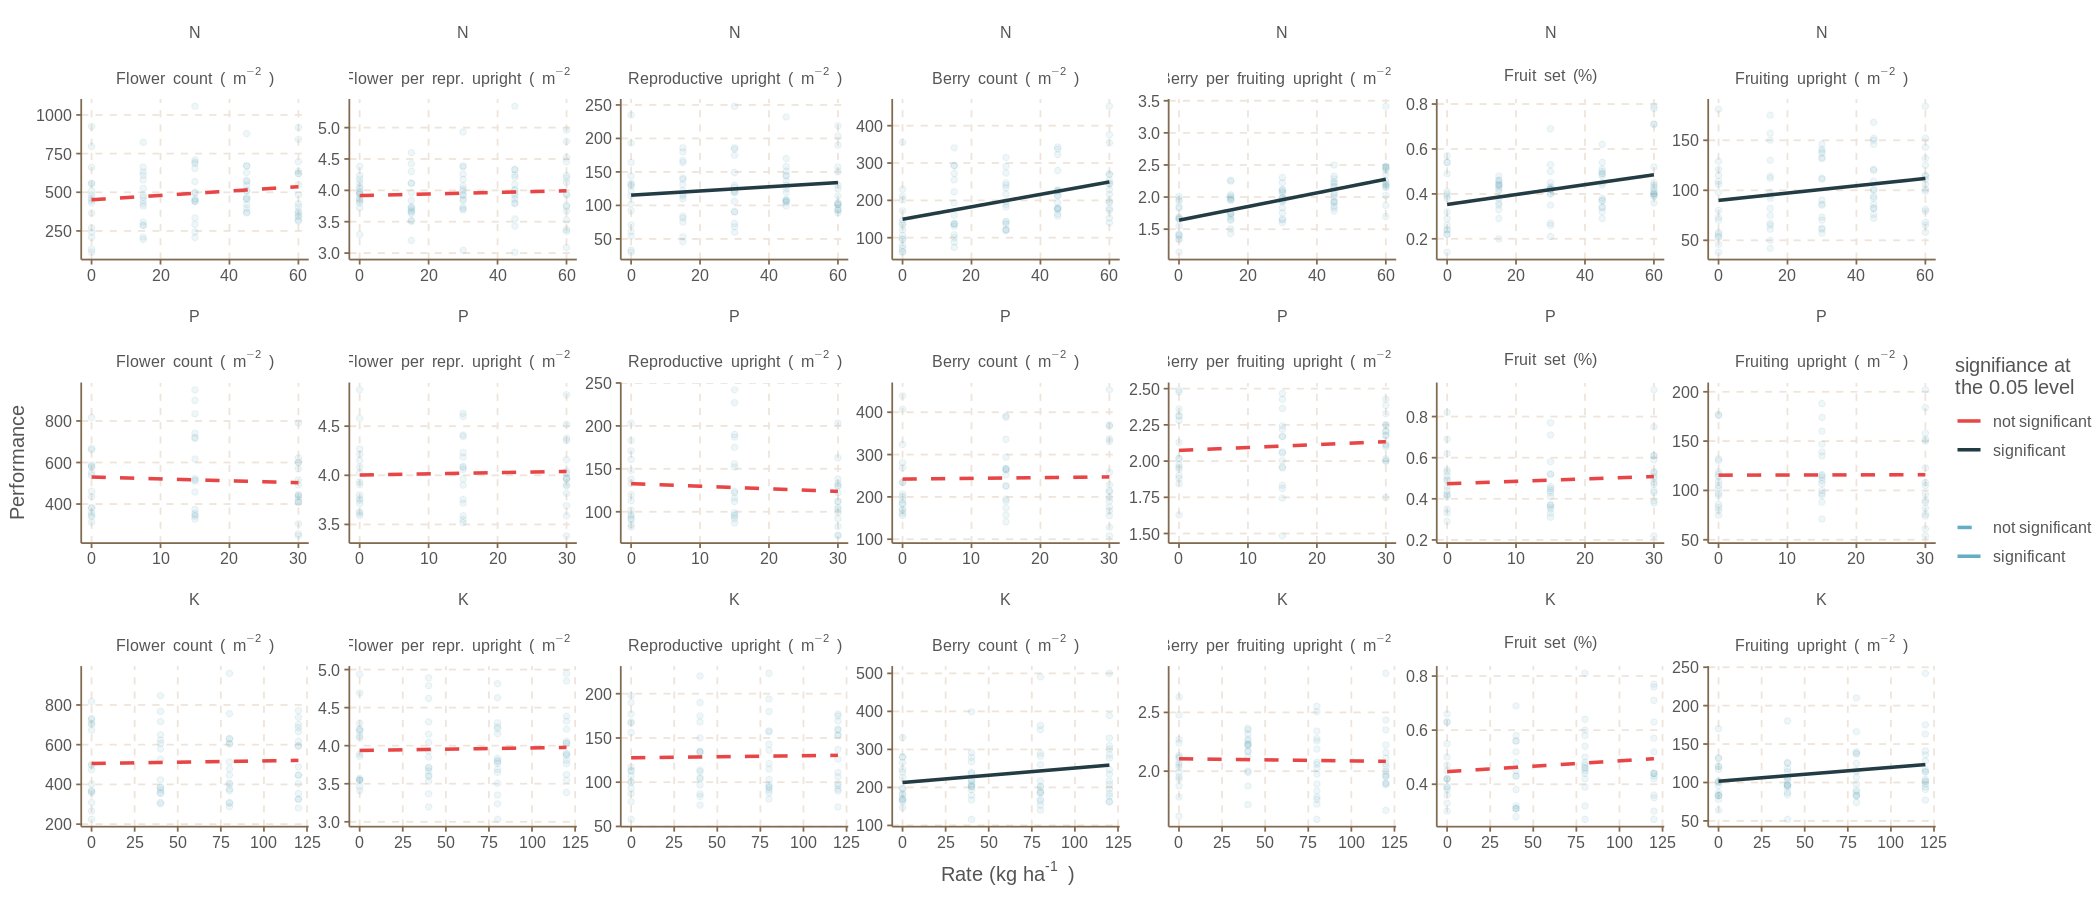

In [18]:
options(repr.plot.width = 7 * 2.5, repr.plot.height = 3 * 2.5)

pr_tidy %>%
  filter(Fertilizer %in% c("N", "P", "K") & performance_index %in% physiology_index) %>%
  drop_na() %>%
  ggplot(aes(Rate, performance)) +
    facet_wrap(Fertilizer ~ performance_index_pretty, scales = "free", ncol = 7, labeller = label_parsed) +
    geom_point(alpha = 0.1) +
    geom_line(data = pred %>% filter(Fertilizer %in% c("N", "P", "K") & performance_index %in% physiology_index) %>% drop_na(),
              aes(colour = is_significant, lty = is_significant), size = 1) +
    labs(x = expression("Rate (kg ha"^"-1"~")"), y = "Performance",
         colour = "signifiance at\nthe 0.05 level", lty = "") +
    scale_linetype_manual(values = c("dashed", "solid")) +
    scale_colour_manual(values = swatch()[4:3])
ggsave("images/grid_macro&physiology.pdf", width=14, height = 6, dpi=300)

#### Secondary-elements

##### Quality

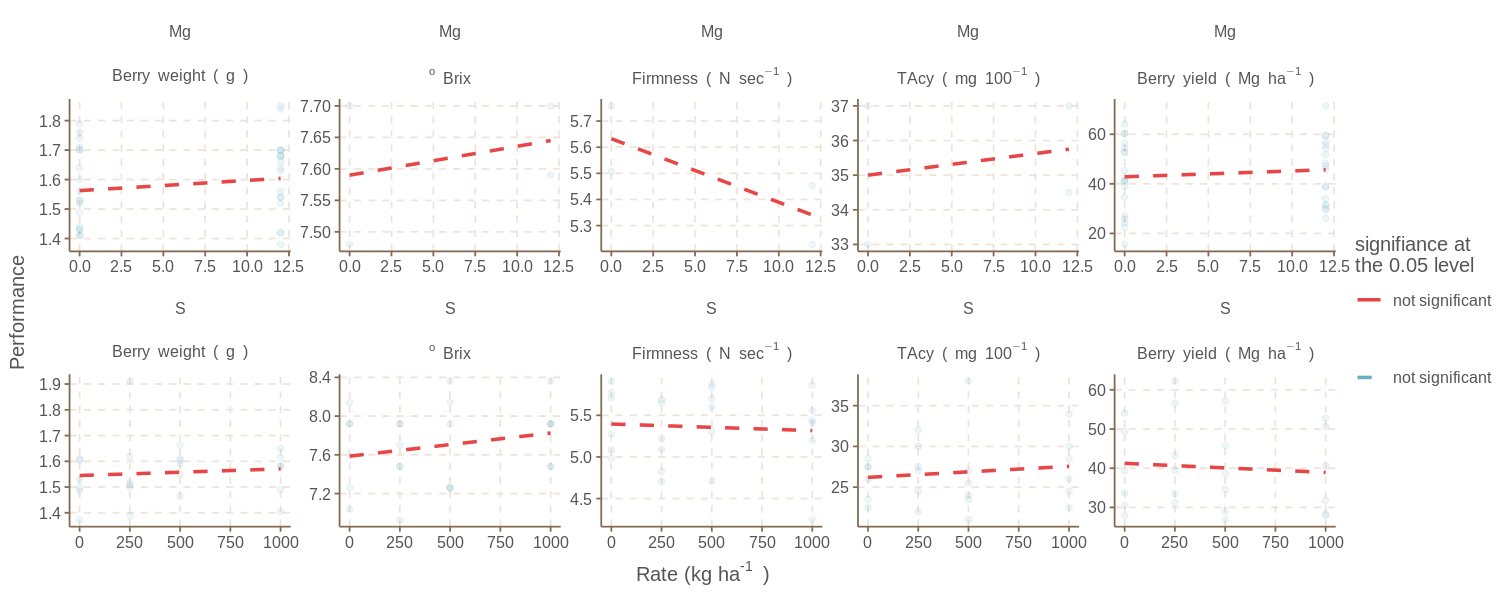

In [19]:
options(repr.plot.width = 5 * 2.5, repr.plot.height = 2 * 2.5)

pr_tidy %>%
  filter(Fertilizer %in% c("Mg", "S") & performance_index %in% quality_index) %>%
  drop_na() %>%
  ggplot(aes(Rate, performance)) +
    facet_wrap(Fertilizer ~ performance_index_pretty, scales = "free", ncol = 5, labeller = label_parsed) +
    geom_point(alpha = 0.1) +
    geom_line(data = pred %>% filter(Fertilizer %in% c("Mg", "S") & performance_index %in% quality_index) %>% drop_na(),
              aes(colour = is_significant, lty = is_significant), size = 1) +
    labs(x = expression("Rate (kg ha"^"-1"~")"), y = "Performance",
         colour = "signifiance at\nthe 0.05 level", lty = "") +
    scale_linetype_manual(values = c("dashed", "solid")) +
    scale_colour_manual(values = swatch()[4:3])
ggsave("images/grid_secondary&quality.pdf", width=10, height = 4, dpi=300)

##### Physiology

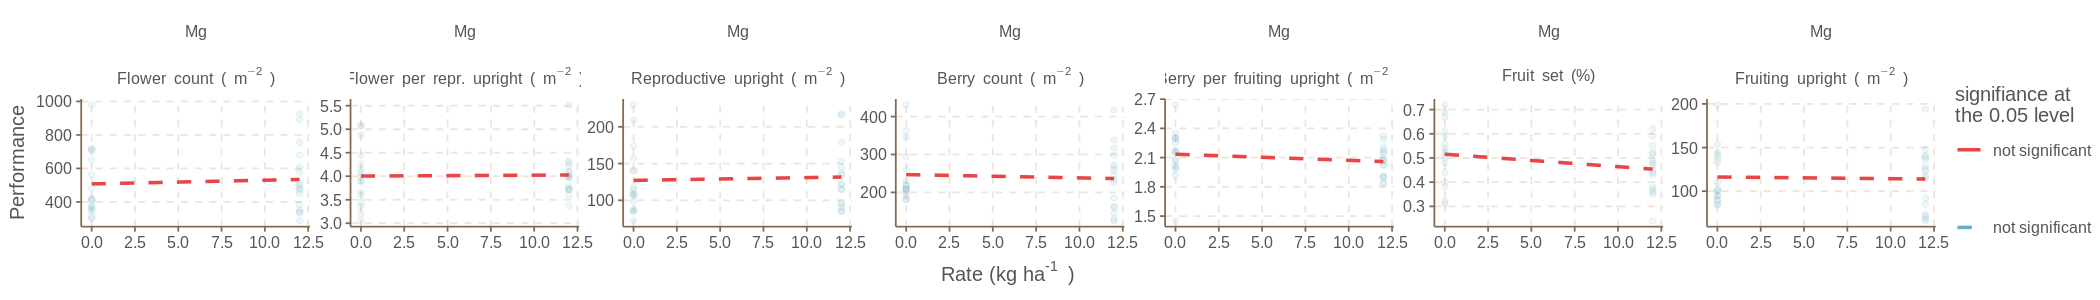

In [20]:
options(repr.plot.width = 7 * 2.5, repr.plot.height = 1 * 2.5)

pr_tidy %>%
  filter(Fertilizer %in% c("Mg", "S") & performance_index %in% physiology_index) %>%
  drop_na() %>%
  ggplot(aes(Rate, performance)) +
    facet_wrap(Fertilizer ~ performance_index_pretty, scales = "free", ncol = 7, labeller = label_parsed) +
    geom_point(alpha = 0.1) +
    geom_line(data = pred %>% filter(Fertilizer %in% c("Mg", "S") & performance_index %in% physiology_index) %>% drop_na(),
              aes(colour = is_significant, lty = is_significant), size = 1) +
    labs(x = expression("Rate (kg ha"^"-1"~")"), y = "Performance",
         colour = "signifiance at\nthe 0.05 level", lty = "") +
    scale_linetype_manual(values = c("dashed", "solid")) +
    scale_colour_manual(values = swatch()[4:3])
ggsave("images/grid_secondary&physiology.pdf", width=14, height = 2, dpi=300)

#### Micro-elements

##### Quality

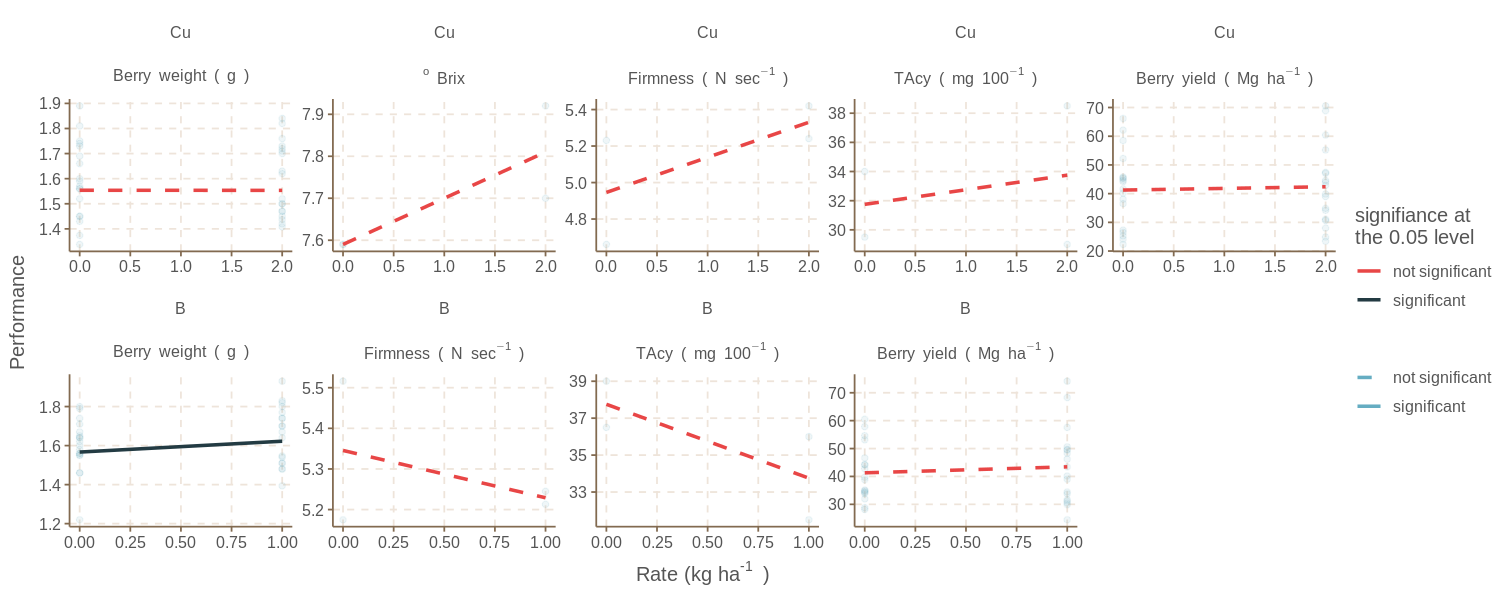

In [21]:
options(repr.plot.width = 5 * 2.5, repr.plot.height = 2 * 2.5)

pr_tidy %>%
  filter(Fertilizer %in% c("B", "Cu") & performance_index %in% quality_index) %>%
  filter(Fertilizer != "B" | performance_index != "Brix") %>%
  drop_na() %>%
  ggplot(aes(Rate, performance)) +
    facet_wrap(Fertilizer ~ performance_index_pretty, scales = "free", ncol = 5, labeller = label_parsed) +
    geom_point(alpha = 0.1) +
    geom_line(data = pred %>% filter(Fertilizer %in% c("B", "Cu") & performance_index %in% quality_index) %>% drop_na(),
              aes(colour = is_significant, lty = is_significant), size = 1) +
    labs(x = expression("Rate (kg ha"^"-1"~")"), y = "Performance",
         colour = "signifiance at\nthe 0.05 level", lty = "") +
    scale_linetype_manual(values = c("dashed", "solid")) +
    scale_colour_manual(values = swatch()[4:3])
ggsave("images/grid_micro&quality.pdf", width=10, height = 4, dpi=300)

##### Physiology

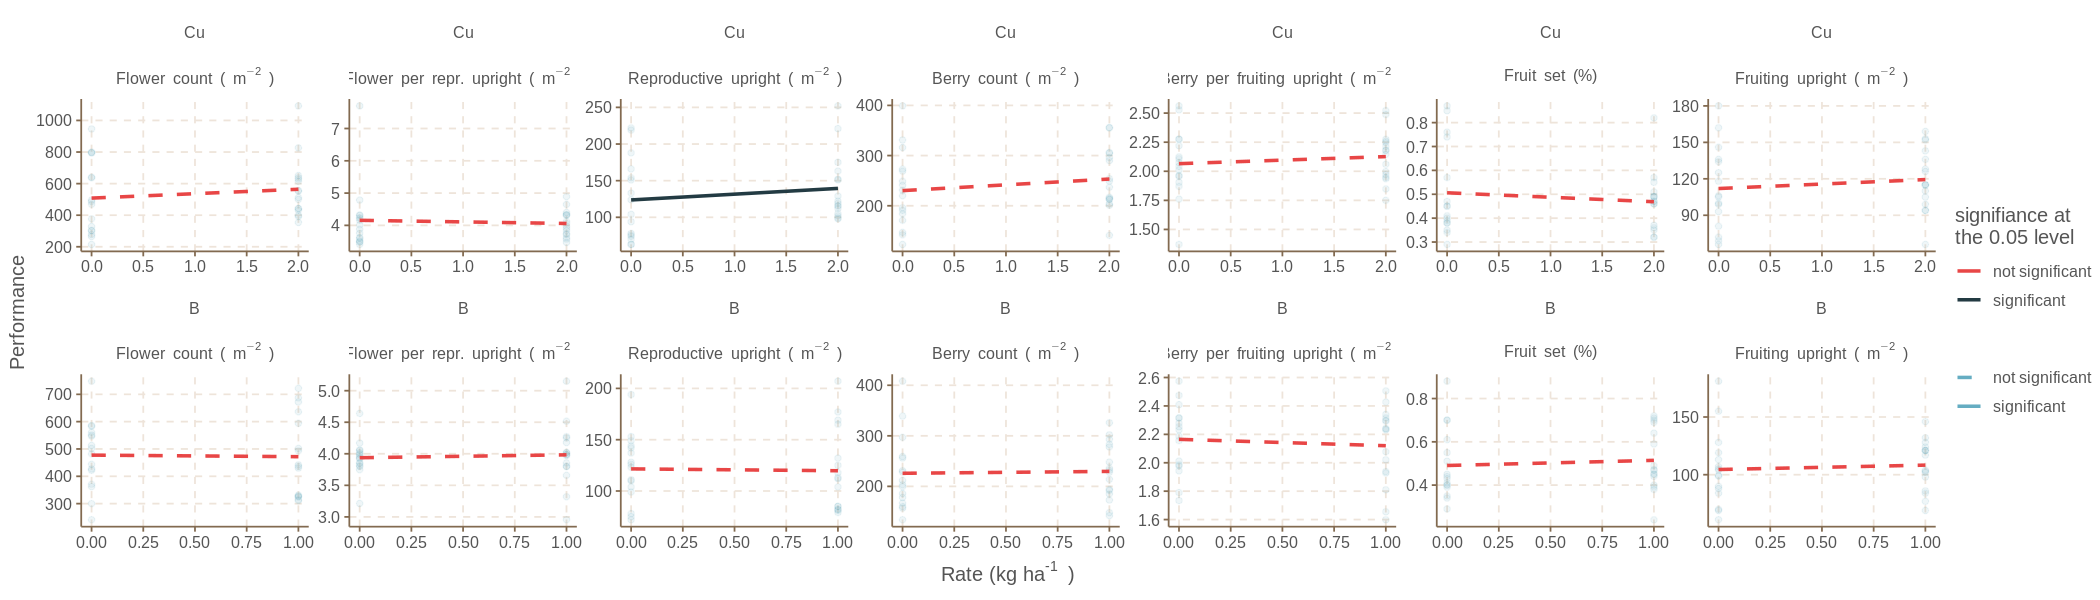

In [22]:
options(repr.plot.width = 7*2.5, repr.plot.height = 2*2.5)

pr_tidy %>%
  filter(Fertilizer %in% c("B", "Cu") & performance_index %in% physiology_index) %>%
  drop_na() %>%
  ggplot(aes(Rate, performance)) +
    facet_wrap(Fertilizer ~ performance_index_pretty, scales = "free", ncol = 7, labeller = label_parsed) +
    geom_point(alpha = 0.1) +
    geom_line(data = pred %>% filter(Fertilizer %in% c("B", "Cu") & performance_index %in% physiology_index) %>% drop_na(),
              aes(colour = is_significant, lty = is_significant), size = 1) +
    labs(x = expression("Rate (kg ha"^"-1"~")"), y = "Performance",
         colour = "signifiance at\nthe 0.05 level", lty = "") +
    scale_linetype_manual(values = c("dashed", "solid")) +
    scale_colour_manual(values = swatch()[4:3])
ggsave("images/grid_micro&physiology.pdf", width=14, height = 4, dpi=300)